# Methylation and Deamination Estimators Simulation : Liran vs. Us

Author: lee.carlin@mail.huji.ac.il  
Date: 2020-05-24 
Last edited: 2020-05-26 

* Revising the generative model according to Benny's suggestions: building the model without the `i` index and ignoring pi_zero. 
* Simulating again according to the model above, with more structured pi vectored (as discussed in last week's meeting. 
* Try to calculate pi in my simulations from the real data we have (last iteration where we showed the trend of deamination along the reads)  
* m_i values coming closer to the real distribution ( e.g. a mixture with a component at 0.1 and one at 0.7). 

TODO:
* Try to isolate the bias-variance into :
    Choose 10 different m_i, for each generate 8 different pi_i (vectors), for each simulate 100 t_i. 
    You can get the estimator sd given pi_i and m_i. Compare to my likelihood sd (should be the same). 
    you can also get the differences between the means (this is because pi_i is different). 
    In addition: compare the situation between same m_i to varied m_i per i. 
* Maybe we should also do some regularization (empirical base on dist of m_i). (later)

HighLevel:
* IF the variance of pi is small enough, the old model is good enough. 
* However, if not, the conditional is better. 
* So- can we find the threshold / set of conditions to choose one over the other? In terms of standard deviation/ other moments. 

* 

In [455]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton
import scipy.stats as stats  
import time
import statistics
import seaborn as sns
import random

# Second Order Condition:
def SOC_binom(t,pi, m, n):   
    return -(((n-t)*(pi**2))/(1-pi*m)**2).sum()

 
# Squaring a list:
def square(list):
    return map(lambda x: x ** 2, list)

# MLE (no pi_zero):
def FOC(M,n,pi,t):    
    theta = pi*M
    A = (t/M).sum()
    oneMinusT = np.array([1]*n)-np.array(t)
    oneMinusTheta = np.array([1]*n)-theta
    B = ((oneMinusT*pi)/(oneMinusTheta)).sum()
    return (A-B)

def SOC(M,n,pi,t):    
    A = (t/M**2).sum()
    oneMinusT = np.array([1]*n)-np.array(t)
    oneMinusTheta = np.array([1]*n)-pi*M
    B = ((oneMinusT*(pi**2))/(oneMinusTheta)**2).sum()
    return (-A-B)


# Simulating Data:

Using a position depended Binomial model $t_{r} \sim Bern(\theta_{r})$   
for  $\theta$ such that  $\quad \theta_{r} =  m \times\pi _{r}$  
simulate a vector of $t_r$ for $r \in [1,2,\dots,c]$ and estimate $m$ using Liran's and our models:

In [487]:
# Parameters:
# General:
###########################################
sample_len = 1000 # "DNA" sample length-> N
coverage_mean  = 100
coverage_sd = 5
#m_mean =  0.6
m_sd = 0.05
m_low = 0.2
m_high = 0.8
# Parameters for complex model:
m_initial_guess = 0.7 # for complex model
###########################################

# list objects for accounting:
t_list = []
est_simple_list = []
sd_simple_list = []
est_complex_list = []
sd_complex_list = []
pi_list = []
pi_mean_list = []
m_list = []
###########################################

# Simulating Data:
rng = range(0,sample_len) 
for i in rng:
    # Sampling m_i:
    #m = np.random.normal(m_mean, m_sd)
    m = random.sample([m_low,m_high],1)[0]
    #m = np.random.normal(m,m_sd,1)
    #random.sample(np.random.normal(m_low, m_sd),np.random.normal(m_high, m_sd),)
    #
    if m>=1:
        m  = 0.9999
    elif m <=0:
        m = 0.0001
    #Sampling coverage:
    coverage = int(np.random.normal(coverage_mean, coverage_sd))
    # Sampling pi_i and pi_i_zero from a uniform dist:
    #pi = np.random.uniform(low=0.02, high=0.8, size=coverage)
    pi = np.array(2*[0.8]+2*[0.4]+2*[0.2]+(coverage-6)*[0.02])
    theta = pi*m # Defining theta
    # Limiting theta:
    theta[theta>0.999]=0.9999
    theta[theta<0]=0.0001
    # Sampling t_i from a binomial(theta):
    t = np.random.binomial(1,theta)
    
    # Estimating using Liran's:
    pi_calib = 0.04699 
    solution_simple = t.sum()/(coverage*pi_calib) #MLE: m_i = t_i/(pi*n_i)
    est_simple_list.append(solution_simple)
    sd_simple_list.append(np.sqrt(1/(-SOC_binom(t,pi_calib, solution_simple, coverage))))
    
    # Estimating m_i using complex model: 
    solution = fsolve(FOC, m_initial_guess,args=(coverage,pi,t))[0]
    #solution = sp.optimize.brentq(FOC,a = 0, b = 1 ,args=(coverage,pi,t))
    #solution = sp.optimize.root_scalar(FOC,args=(coverage,pi,t),bracket=[0,1], method='bisect').root
    if solution<0:
        solution=0
    if solution >1:
        solution = 1
    est_complex_list.append(solution)
    sd_complex_list.append(np.sqrt(1/(-SOC(solution,coverage,pi,t))))
    
    # Accounting:
    pi_list.append(pi)
    pi_mean_list.append(pi.mean())
    m_list.append(m)
    t_list.append(t)
    
output_df = pd.DataFrame(list(zip(m_list, pi_list ,t_list)), 
               columns =['samp_m', 'samp_p','samp_t']) 
#output_df.to_pickle('/Users/leecarlin/Dropbox (Personal)/School/deamination/simulation_MLE_35_coverage.pickle')

print('The empirical mean of m: {:,}'.format(np.array(m_list).mean()))
print('The empirical mean of pi: {:,}'.format(np.array(pi_mean_list).mean()))
print('The empirical mean of theta: {:,}'.format(np.array(pi_mean_list).mean()*np.array(m_list).mean()))

print('The mean of the simple model estimation: {:,}'.format(np.array(est_simple_list).mean()))
print('The mean of the complex model estimation: {:,}'.format(np.array(est_complex_list).mean()))
print('The std of the simple model estimation: {:,}'.format(np.array(est_simple_list).std()))
print('The std of the complex model estimation: {:,}'.format(np.array(est_complex_list).std()))
print('The mean of the simple model MLE STD: {:,}'.format(np.array(sd_simple_list).mean()))
print('The mean of the complex model STD: {:,}'.format(np.array(sd_complex_list).mean()))
MSE_liran = np.sqrt(((np.array(est_simple_list)-np.array(m_list))**2).mean())
MSE = np.sqrt(((np.array(est_complex_list)-np.array(m_list))**2).mean())
print('RMSE of Lirans Model: {:,}'.format(MSE_liran))
print('RMSE of Our Model: {:,}'.format(MSE))
print('RMSE DIfference: {:%}'.format((MSE-MSE_liran)/MSE_liran))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


The empirical mean of m: 0.49520000000000003
The empirical mean of pi: 0.04704996706904751
The empirical mean of theta: 0.02329914369259233
The mean of the simple model estimation: 0.4984598639227687
The mean of the complex model estimation: 0.4684294797394326
The std of the simple model estimation: 0.43022429074875035
The std of the complex model estimation: 0.362335181353365
The mean of the simple model MLE STD: 0.20976194151936875
The mean of the complex model STD: nan
RMSE of Lirans Model: 0.29169344701841404
RMSE of Our Model: 0.2290638644846288
RMSE DIfference: -21.471028%


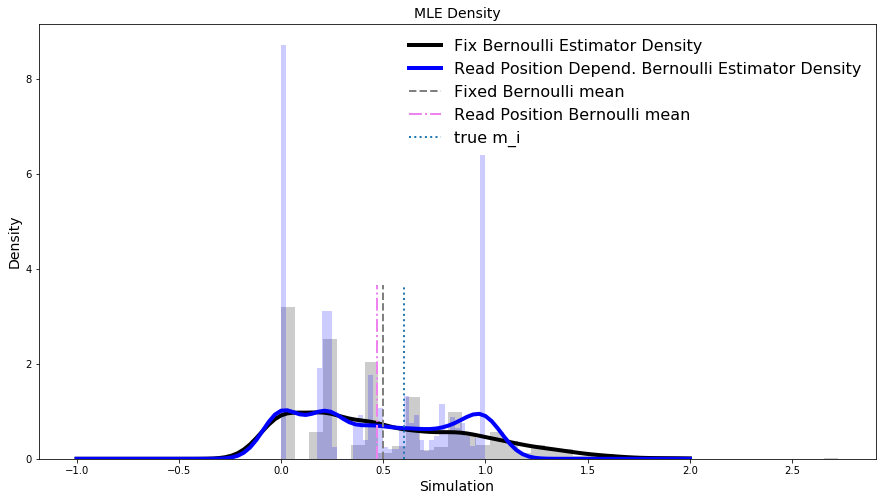

In [488]:
#Plot the distribution of our MLE and Lirans MLE 
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde
density_liran = gaussian_kde(est_simple_list)
density_our = gaussian_kde(est_complex_list)
xs = np.linspace(-1,2,100)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
ax.plot(xs,density_liran(xs), color = 'black', label = 'Fix Bernoulli Estimator Density',lw=4)
ax.hist(est_simple_list, density=True, bins= 40, alpha = 0.2, color = 'black')
ax.plot(xs,density_our(xs), color = 'blue', label = 'Read Position Depend. Bernoulli Estimator Density',lw=4)
ax.hist(est_complex_list, density=True, bins= 40, alpha = 0.2, color = 'blue')

ax.axvline(np.array(est_simple_list).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Fixed Bernoulli mean', color = 'grey',lw=2)
ax.axvline(np.array(est_complex_list).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='Read Position Bernoulli mean', color = 'violet',lw=2)
ax.axvline(m_mean,ymin=0, ymax= 0.4 ,linestyle = ':', label='true m_i',lw=2)
ax.legend(fontsize = 16,frameon = False)
plt.xlabel('Simulation', fontsize=14)
plt.ylabel('Density', fontsize=14)
ax.set_title('MLE Density', fontsize=14)
#fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_20200528/fig1.png',dpi=400)
plt.show()

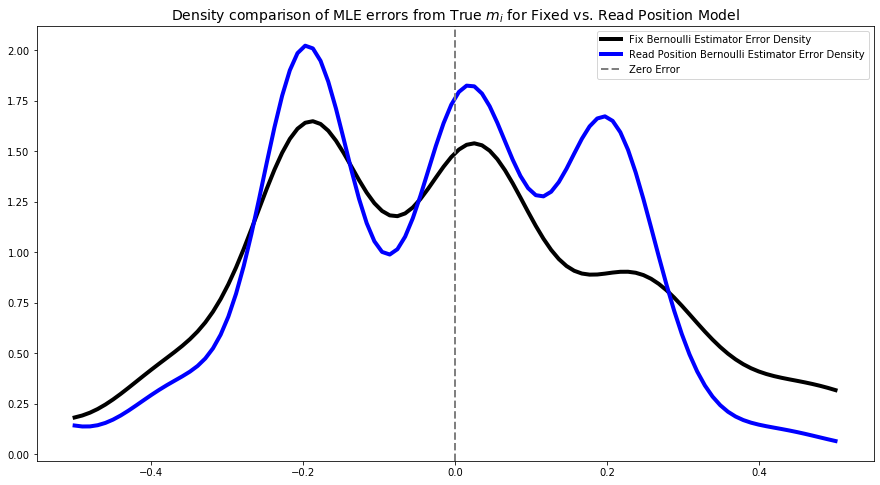

In [489]:
tmp = pd.DataFrame(list(zip(np.array(est_simple_list)-np.array(m_list), np.array(est_complex_list)-np.array(m_list))), 
               columns =['fixed_est', 'our_est'])
#tmp = tmp.sort_values('our_est', ascending=False)
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
density_diff_fixed = gaussian_kde(tmp.fixed_est)
density_diff_our = gaussian_kde(tmp.our_est)
xs = np.linspace(-0.5,0.5,100)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
ax.plot(xs,density_diff_fixed(xs), color = 'black', label = 'Fix Bernoulli Estimator Error Density',lw=4, )
ax.plot(xs,density_diff_our(xs), color = 'blue', label = 'Read Position Bernoulli Estimator Error Density',lw=4)

ax.axvline(0 ,linestyle = '--', label='Zero Error', color = 'grey',lw=2)
ax.set_title('Density comparison of MLE errors from True $m_i$ for Fixed vs. Read Position Model', fontsize=14)
ax.legend()
#fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_20200528/fig2.png',dpi=400)
plt.show()

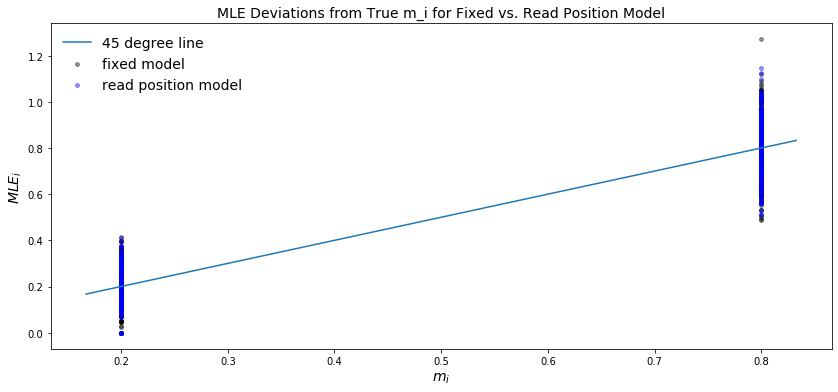

In [475]:
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
ax.scatter(m_list,est_simple_list, color='black', alpha = 0.4, label = 'fixed model', s=15 )
ax.scatter(m_list,est_complex_list, color='blue', alpha = 0.4, label = 'read position model', s=15)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, label = '45 degree line')
ax.set_title('MLE Deviations from True m_i for Fixed vs. Read Position Model', fontsize=14)
plt.xlabel('$m_i$', fontsize=14)
plt.ylabel('$MLE_i$', fontsize=14)
plt.legend(loc='upper left',frameon = False,fontsize= 14)
#fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_may_2020/fig3.png',dpi=400)
plt.show()